# Real data application

Apply the Euler inversion method to real aeromagnetic data from the state of Rio de Janeiro, Brazil. This is a survey made available by the [Brazilian Geologic Survey](https://geosgb.sgb.gov.br/geosgb/downloads_en.html). It's a nice dataset because a section of it has many linear features cutting through some dipolar features.

In [1]:
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from IPython.display import Image
import verde as vd
import harmonica as hm
import euler
import pygmt
import xarray as xr
import pyproj

In [2]:
warnings.filterwarnings("ignore")

## Load the data

Load the processed magnetic data from a CSV file (see `real-data-preparation.ipynb`).

In [3]:
data_dir = Path("..") / "data"

In [4]:
data = pd.read_csv(data_dir / "rio-de-janeiro-magnetic.csv")
data

,longitude,latitude,total_field_anomaly_nT,altitude_m,line_number,easting_m,northing_m,geometric_height_m,deriv_up,deriv_east,deriv_north
0,-42.640141,-22.290868,-16.56,151.49,2800,-4.393933e+06,-2.342247e+06,1409.274167,0.191042,0.017813,-0.096147
1,-42.640126,-22.291738,-43.47,162.46,2800,-4.393932e+06,-2.342343e+06,1444.244000,0.134331,0.025458,-0.116888
2,-42.640111,-22.292608,-65.38,170.69,2800,-4.393930e+06,-2.342440e+06,1418.474000,0.095536,0.036430,-0.151500
3,-42.640095,-22.293493,-74.29,173.43,2800,-4.393929e+06,-2.342538e+06,1368.214000,0.038965,0.052054,-0.195592
4,-42.640080,-22.294363,-67.20,170.08,2800,-4.393927e+06,-2.342634e+06,1362.864000,-0.050256,0.063335,-0.179653
...,...,...,...,...,...,...,...,...,...,...,...
50877,-41.905811,-22.497356,163.33,143.87,4600,-4.318263e+06,-2.365128e+06,145.223500,-0.021279,0.000256,-0.043111
50878,-41.905811,-22.498226,175.29,142.34,4600,-4.318263e+06,-2.365225e+06,143.693500,-0.032221,0.002482,-0.035659
50879,-41.905827,-22.499081,180.25,140.51,4600,-4.318265e+06,-2.365320e+06,139.863500,-0.040524,0.005149,-0.027047
50880,-41.905827,-22.499935,175.21,138.68,4600,-4.318265e+06,-2.365414e+06,139.033500,-0.045282,0.007796,-0.017774


Also load a topography grid of SRTM as geometric heights. We'll need this to convert the estimated heights of the sources to depths below the surface.

In [5]:
topography = xr.load_dataarray(data_dir / "rio-de-janeiro-topography.nc")
topography

<xarray.DataArray 'z' (latitude: 2881, longitude: 3391)> Size: 78MB
array([[396.12000012, 390.12033346, 380.12066679, ..., -48.30811408,
        -48.30840518, -48.30874968],
       [379.12033346, 376.12066679, 365.12100012, ..., -48.30511454,
        -48.30537026, -48.30570228],
       [359.12066679, 355.12100012, 349.12133346, ..., -48.30375531,
        -48.30396804, -48.30426469],
       ...,
       [239.33666671, 237.33616672, 232.33566672, ..., 111.77132222,
        122.76982777, 133.76833332],
       [229.33583337, 227.33533338, 224.33483338, ...,  94.7721611 ,
        112.77066388, 125.76916665],
       [212.33500004, 211.33450004, 211.33400005, ...,  77.77299999,
         97.77149998, 116.76999998]])
Coordinates:
  * latitude   (latitude) float64 23kB -22.7 -22.7 -22.7 ... -21.9 -21.9 -21.9
  * longitude  (longitude) float64 27kB -42.74 -42.74 -42.74 ... -41.8 -41.8

## Run Euler inversion

Use the moving windows version of Euler inversion to estimate source depths. Use the flight-line data instead of a grid because our windowing scheme doesn't depend on grids.

In [6]:
%%time
window_size = 12e3
window_step = window_size / 5
weights = (1, 0.1, 0.1, 0.05)
euler_windows = euler.EulerInversionWindowed(
    window_size=window_size,
    window_step=window_step,
    keep=0.15,
).fit(
    coordinates=(
        data.easting_m.values,
        data.northing_m.values,
        data.geometric_height_m.values,
    ),
    data=(
        data.total_field_anomaly_nT.values,
        data.deriv_east.values,
        data.deriv_north.values,
        data.deriv_up.values,
    ),
    weights=weights,
)

CPU times: user 436 ms, sys: 148 ms, total: 584 ms
Wall time: 2.56 s


Also run the inversion without the windowing scheme on some set data windows to investigate some of the more prominent sources.

In [7]:
areas = [
    [-4.39e6, -4.375e6, -2.345e6, -2.33e6],
    [-4.365e6, -4.345e6, -2.35e6, -2.33e6],
    [-4.35e6, -4.335e6, -2.34e6, -2.325e6],
    [-4.35e6, -4.33e6, -2.36e6, -2.340e6],
]
area_solutions = []
area_names = "ABCDE"
for area in areas:
    data_area = data[vd.inside((data.easting_m, data.northing_m), area)]
    coordinates = (
        data_area.easting_m.values,
        data_area.northing_m.values,
        data_area.geometric_height_m.values,
    )
    euler_data = (
        data_area.total_field_anomaly_nT.values,
        data_area.deriv_east.values,
        data_area.deriv_north.values,
        data_area.deriv_up.values,
    )
    candidates = []
    for si in [1, 2, 3]:
        candidates.append(
            euler.EulerInversion(structural_index=si).fit(coordinates, euler_data, weights=weights)
        )
    misfits = [ei.data_misfit_[1] for ei in candidates]
    best = candidates[np.argmin(misfits)]
    area_solutions.append(best)

## Convert Euler results from heights to depths

It's more useful to know depth below the surface of the estimates than their geometric heights. We'll use our topography to convert the estimated heights to depths by interpolation.

In [8]:
table = vd.grid_to_table(topography)
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
kn = vd.KNeighbors().fit(projection(table.longitude, table.latitude), table.z)
euler_depths = kn.predict(euler_windows.locations_[0:2]) - euler_windows.locations_[2] 

## Make a figure for the paper

Plot a map with the data, Euler inversion solutions, and the individual areas as well with their independent solutions.

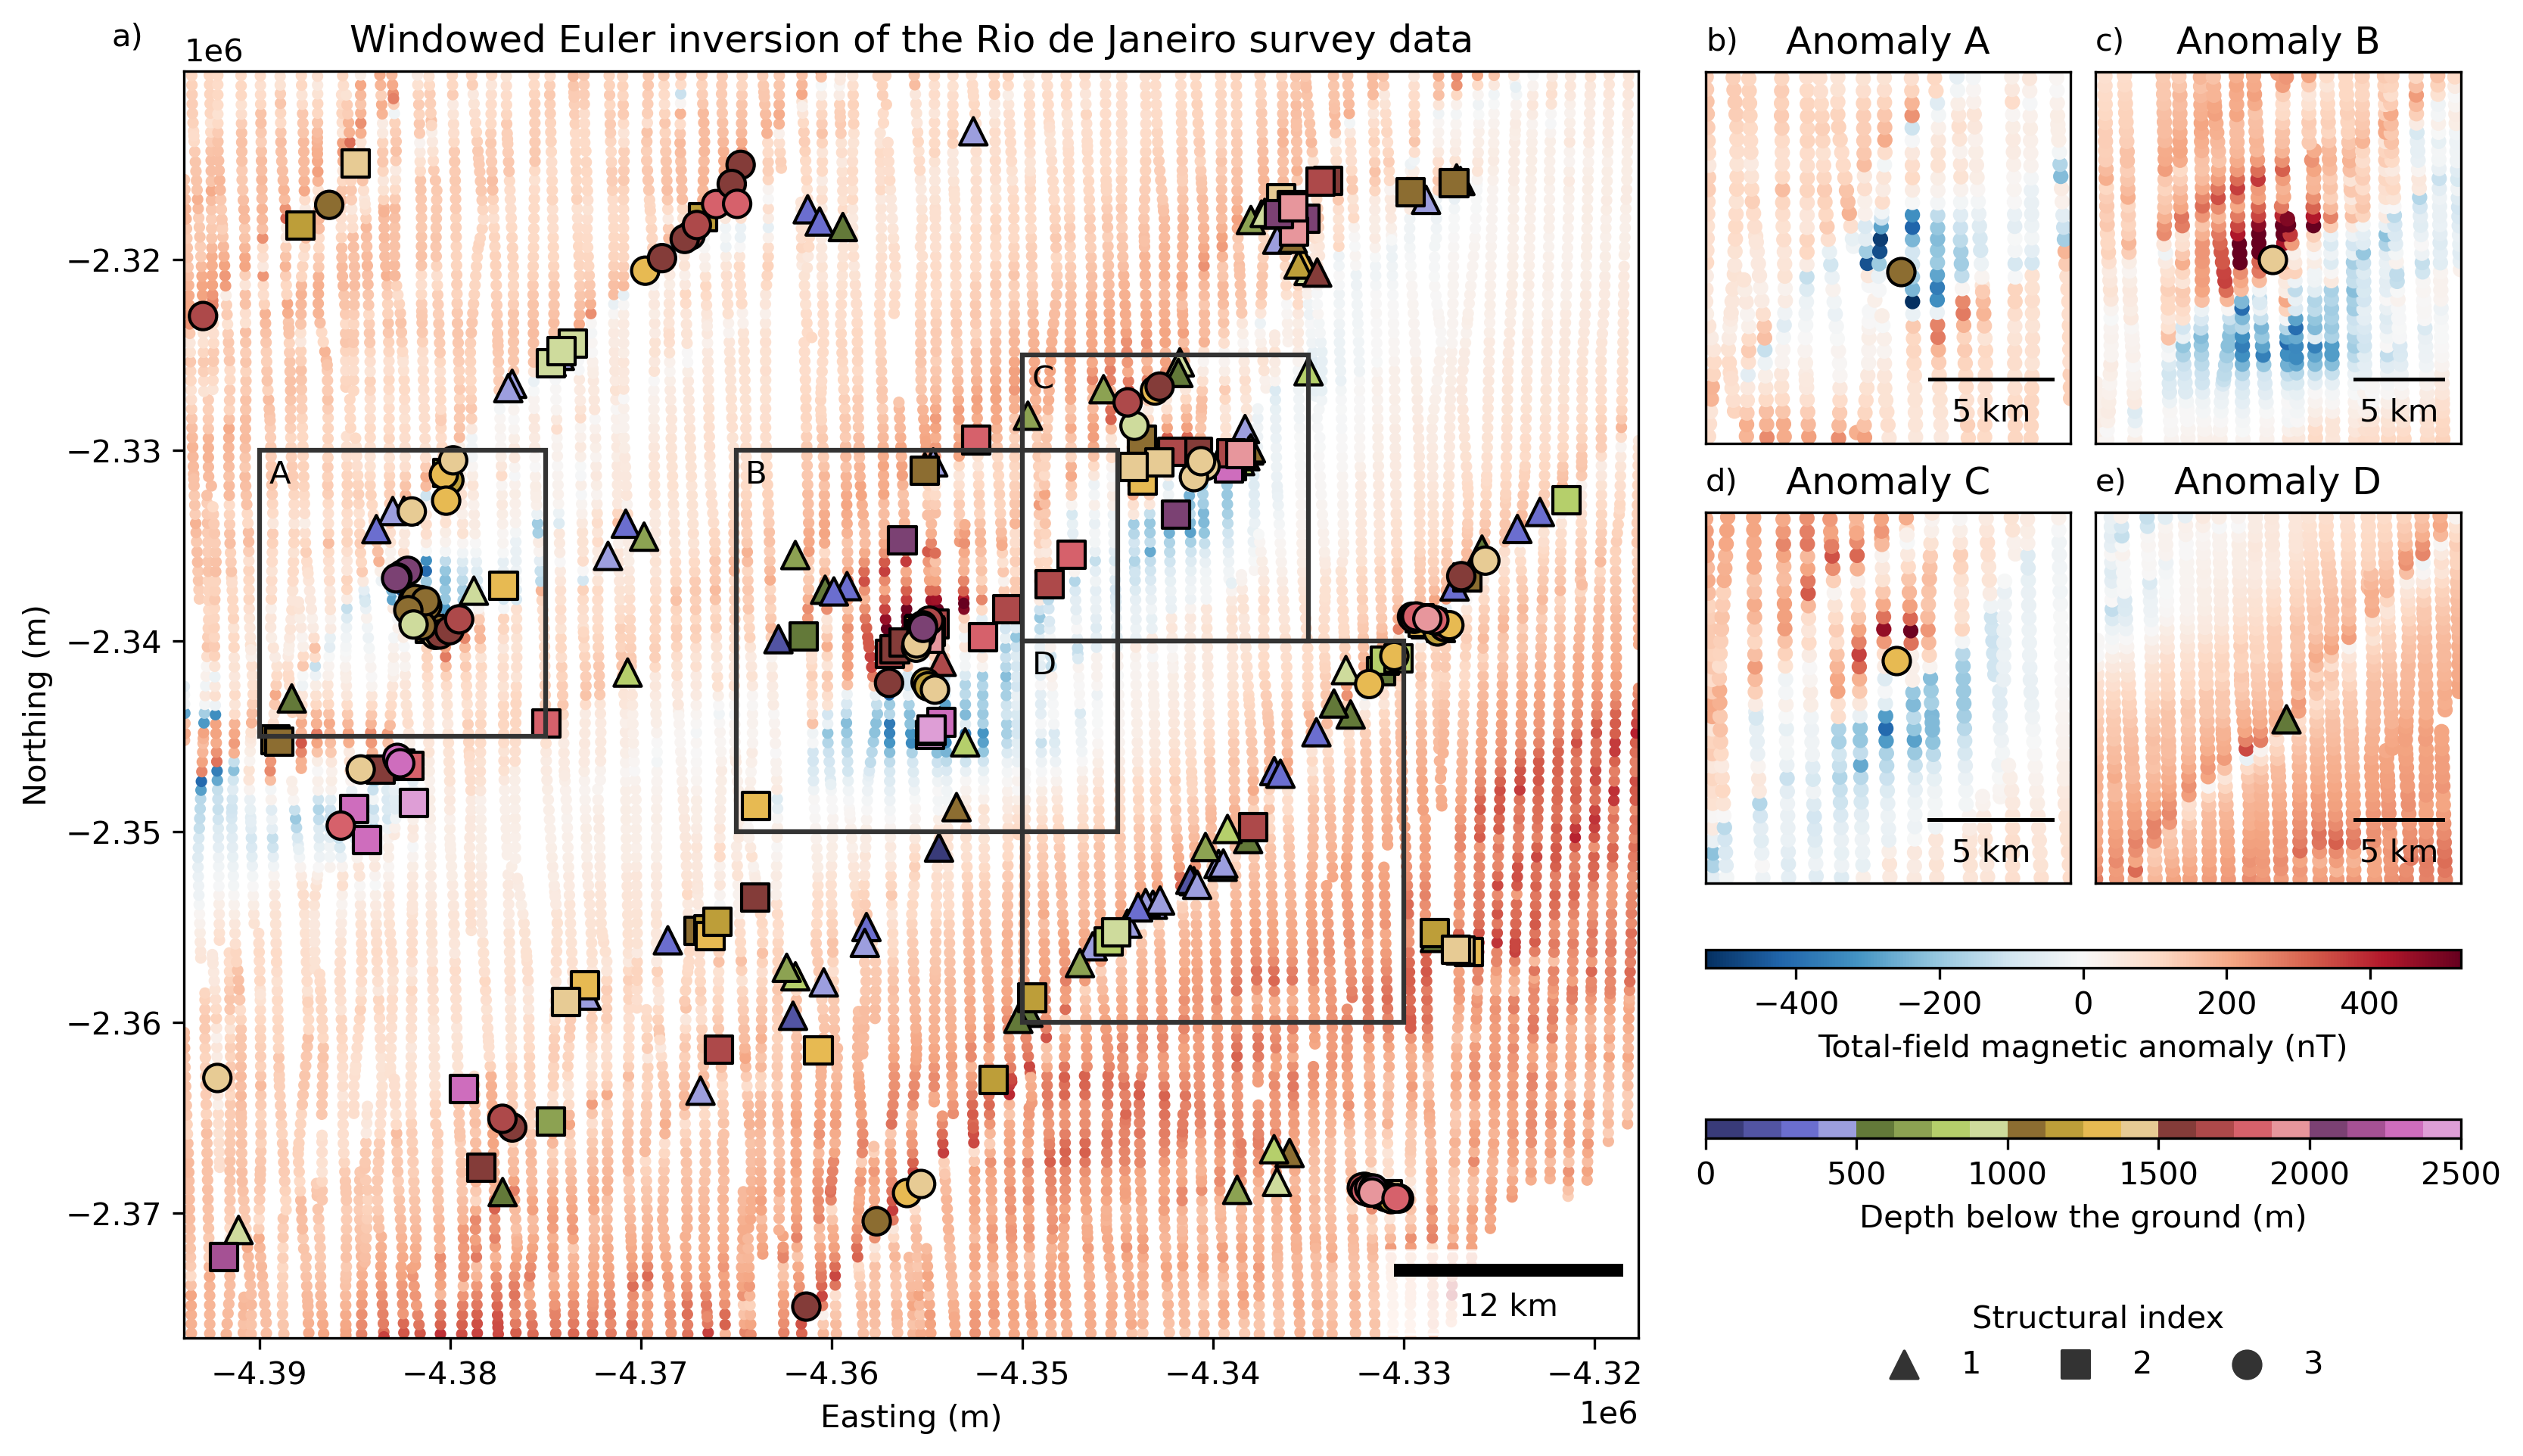

In [9]:
fig = plt.figure(figsize=(11, 6.3), layout="constrained")
figures = fig.subfigures(1, 2, width_ratios=[2, 1])

ax = figures[0].subplots(1, 1)
scale = np.percentile(np.abs(data.total_field_anomaly_nT), 99.9)
block_coords, block_mag = vd.BlockReduce(np.median, spacing=500).filter(
    (data.easting_m, data.northing_m), data.total_field_anomaly_nT
)
tmp_data = ax.scatter(
    *block_coords, s=7, c=block_mag, vmin=-scale, vmax=scale, cmap="RdBu_r"
)
ax.set_title("Windowed Euler inversion of the Rio de Janeiro survey data")
ax.text(-0.05, 1.02, "a)", transform=ax.transAxes)
ax.set_aspect("equal")
ax.set_xlim(data.easting_m.min(), data.easting_m.max())
ax.set_ylim(data.northing_m.min(), data.northing_m.max())
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
markers = ["^", "s", "o"]
labels = {}
size = 75
vmin, vmax = 0, 2500
for si, marker in zip([1, 2, 3], markers):
    is_si = euler_windows.structural_indices_ == si
    tmp = ax.scatter(
        *euler_windows.locations_[:2, is_si],
        c=euler_depths[is_si],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=1,
        cmap="tab20b",
    )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)
ax.add_artist(
    ScaleBar(
        dx=0.001,
        fixed_value=window_size / 1000,
        units="km",
        location="lower right",
        box_alpha=0.8,
        color="black",
        scale_loc="bottom",
        width_fraction=0.01,
        length_fraction=0.1,
        pad=0.4,
        scale_formatter=lambda value, unit: f"{value:.0f} {unit}",
    )
)

for area, name in zip(areas, area_names):
    ax.add_patch(
        plt.Rectangle(
            xy=(area[0], area[2]),
            width=area[1] - area[0],
            height=area[3] - area[2],
            fill=None,
            edgecolor="#333333",
            linewidth=1.5,
        )
    )
    ax.text(area[0] + 0.5e3, area[3] - 0.5e3, name, verticalalignment="top")

axes = figures[1].subplots(2, 2)
for area, name, ei, ax, label in zip(
    areas, area_names, area_solutions, axes.ravel(), "bcde"
):
    data_area = data[vd.inside((data.easting_m, data.northing_m), area)]
    block_coords, block_mag = vd.BlockReduce(np.median, spacing=500).filter(
        (data_area.easting_m, data_area.northing_m), data_area.total_field_anomaly_nT
    )
    ax.scatter(*block_coords, c=block_mag, s=15, vmin=-scale, vmax=scale, cmap="RdBu_r")
    # ax.set_aspect("equal")
    ax.set_xlim(data_area.easting_m.min(), data_area.easting_m.max())
    ax.set_ylim(data_area.northing_m.min(), data_area.northing_m.max())
    ax.set_title(f"Anomaly {name}")
    ax.tick_params(
        axis="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )
    ax.scatter(
        *ei.location_[:2],
        c=kn.predict(ei.location_[0:2]) - ei.location_[2],
        s=size,
        marker=markers[ei.structural_index - 1],
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=1,
        cmap="tab20b",
    )
    ax.add_artist(
        ScaleBar(
            dx=1,
            units="m",
            location="lower right",
            box_alpha=0,
            color="black",
            scale_loc="bottom",
            width_fraction=0.01,
            length_fraction=0.5,
            pad=0.4,
        )
    )
    ax.text(0, 1.06, f"{label})", transform=ax.transAxes)

figures[1].legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    ncols=3,
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="Structural index",
    loc="outside lower center",
    borderpad=1.5,
)
figures[1].colorbar(
    tmp,
    ax=axes[1, :],
    aspect=40,
    pad=0.15,
    shrink=1,
    orientation="horizontal",
    label="Depth below the ground (m)",
)
figures[1].colorbar(
    tmp_data,
    ax=axes[1, :],
    aspect=40,
    pad=0.15,
    shrink=1,
    orientation="horizontal",
    label="Total-field magnetic anomaly (nT)",
)
# Save the figure and display the saved figure because savefig and
# show can sometimes create slightly different figures
figfile = Path("..") / "paper" / "figures" / "real-data-application.png"
fig.savefig(figfile, dpi=300, bbox_inches="tight")
plt.close()
Image(figfile)